In [1]:
import os

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

In [2]:
import time

import jax
import jaxgboost

import matplotlib.pyplot as plt
from sklearn import datasets

In [3]:
data = datasets.load_diabetes()
x = data['data']
y = data['target'].reshape(-1, 1)

xt, yt = x[:400], y[:400]
xv, yv = x[400:], y[400:]

ym = yt.mean()
ys = yt.std() + 1e-6

yt = (yt - ym) / ys
yv = (yv - ym) / ys

xt = jax.numpy.array(xt)
xv = jax.numpy.array(xv)
yt = jax.numpy.array(yt)
yv = jax.numpy.array(yv)

In [4]:
static_params = {
    "n_estimators": 100,
    "max_depth": 6,
    "base_score": yt.mean(),
    "jit": False
}

params_vec = {
    "learning_rate": jax.numpy.linspace(0.01, 0.3, 32),
    "reg_lambda": jax.numpy.linspace(0.01, 1.0, 32),
    "reg_alpha": jax.numpy.linspace(0.01, 1.0, 32),
}

### Vectorization with `jax.vmap`

In [5]:
@jax.jit
@jax.vmap
def train_and_eval(params):
    model = jaxgboost.JAXGBoostModel(**params, **static_params)
    model.fit(xt, yt)
    pv = model.predict(xv)
    valid_mse = jax.numpy.mean((yv - pv) ** 2)
    return valid_mse

t0 = time.time_ns()

mse_vmap = train_and_eval(params_vec)
mse_vmap = mse_vmap.block_until_ready()

t1 = time.time_ns()
print("%d ms" % ((t1 - t0) / 1e6))

49041 ms


### Parallelization with `jax.pmap`

In [6]:
@jax.jit
@jax.vmap
def train_and_eval(params):
    model = jaxgboost.JAXGBoostModel(**params, **static_params)
    model.fit(xt, yt)
    pv = model.predict(xv)
    valid_mse = jax.numpy.mean((yv - pv) ** 2)
    return valid_mse


devices = jax.devices('cpu')
train_and_eval_parallel = jax.pmap(jax.jit(train_and_eval), devices=devices)

t0 = time.time_ns()

params_vec_ = {k: v.reshape(len(devices), -1) for k, v in params_vec.items()}
mse_pmap = train_and_eval_parallel(params_vec_).ravel()
mse_pmap = mse_pmap.block_until_ready()

t1 = time.time_ns()
print("%d ms" % ((t1 - t0) / 1e6))

10112 ms


### Comparison

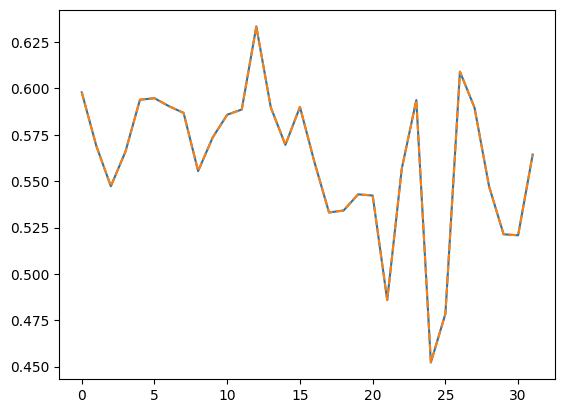

In [7]:
plt.plot(mse_vmap)
plt.plot(mse_pmap, linestyle="--")